In [1]:
# Essential imports
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import timm  # For modern pretrained models

# Set seed for reproducibility
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
class SportsDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None, is_train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        
        # Read CSV file
        self.data = pd.read_csv(os.path.join(root_dir, csv_file))
        
        if is_train:
            # Create class mapping
            unique_classes = sorted(self.data['label'].unique())
            self.class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
            self.idx_to_class = {idx: cls for cls, idx in self.class_to_idx.items()}
            print(f"Classes found: {self.class_to_idx}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get image path and load image
        img_name = self.data.iloc[idx]['image_ID']
        folder = 'train' if self.is_train else 'test'
        img_path = os.path.join(self.root_dir, folder, img_name)
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_train:
            label = self.data.iloc[idx]['label']
            label_idx = self.class_to_idx[label]
            return image, label_idx
        else:
            return image, img_name  # Return image name for test set


In [3]:
# Define transforms
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset path
dataset_path = "/kaggle/input/sports-image-classification/dataset"

# Create full training dataset
full_train_dataset = SportsDataset(
    root_dir=dataset_path,
    csv_file='train.csv',
    transform=train_transform,
    is_train=True
)

# Split into train and validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Update validation dataset transform
val_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(full_train_dataset.class_to_idx)}")


Classes found: {'Badminton': 0, 'Cricket': 1, 'Karate': 2, 'Soccer': 3, 'Swimming': 4, 'Tennis': 5, 'Wrestling': 6}
Training samples: 6581
Validation samples: 1646
Number of classes: 7


In [4]:
# Create model using timm (modern pretrained models)
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=7)
model = model.to(device)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Model created with 4016515 parameters


In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.cpu())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
        
        val_epoch_loss = val_running_loss / len(val_dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_dataset)
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc.cpu())
        
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
        
        # Save best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_sports_model.pth')
            print(f'New best model saved with accuracy: {best_val_acc:.4f}')
        
        scheduler.step()
        print()
    
    return train_losses, val_losses, train_accs, val_accs

# Train the model
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15
)


Epoch 1/15
--------------------
Train Loss: 0.6122 Acc: 0.8310
Val Loss: 0.2678 Acc: 0.9113
New best model saved with accuracy: 0.9113

Epoch 2/15
--------------------
Train Loss: 0.2086 Acc: 0.9372
Val Loss: 0.4126 Acc: 0.9083

Epoch 3/15
--------------------
Train Loss: 0.1656 Acc: 0.9480
Val Loss: 0.2142 Acc: 0.9235
New best model saved with accuracy: 0.9235

Epoch 4/15
--------------------
Train Loss: 0.1457 Acc: 0.9547
Val Loss: 0.2448 Acc: 0.9186

Epoch 5/15
--------------------
Train Loss: 0.1232 Acc: 0.9620
Val Loss: 0.1914 Acc: 0.9490
New best model saved with accuracy: 0.9490

Epoch 6/15
--------------------
Train Loss: 0.0677 Acc: 0.9798
Val Loss: 0.2105 Acc: 0.9447

Epoch 7/15
--------------------
Train Loss: 0.1069 Acc: 0.9687
Val Loss: 0.3291 Acc: 0.9259

Epoch 8/15
--------------------
Train Loss: 0.0405 Acc: 0.9866
Val Loss: 0.1884 Acc: 0.9532
New best model saved with accuracy: 0.9532

Epoch 9/15
--------------------
Train Loss: 0.0099 Acc: 0.9974
Val Loss: 0.1760 Acc:

Classification Report:
              precision    recall  f1-score   support

   Badminton       0.95      0.98      0.97       248
     Cricket       0.99      0.98      0.98       324
      Karate       0.97      0.94      0.95       118
      Soccer       0.97      0.96      0.96       251
    Swimming       0.97      0.96      0.96       122
      Tennis       0.96      0.97      0.96       304
   Wrestling       0.97      0.97      0.97       279

    accuracy                           0.97      1646
   macro avg       0.97      0.97      0.97      1646
weighted avg       0.97      0.97      0.97      1646



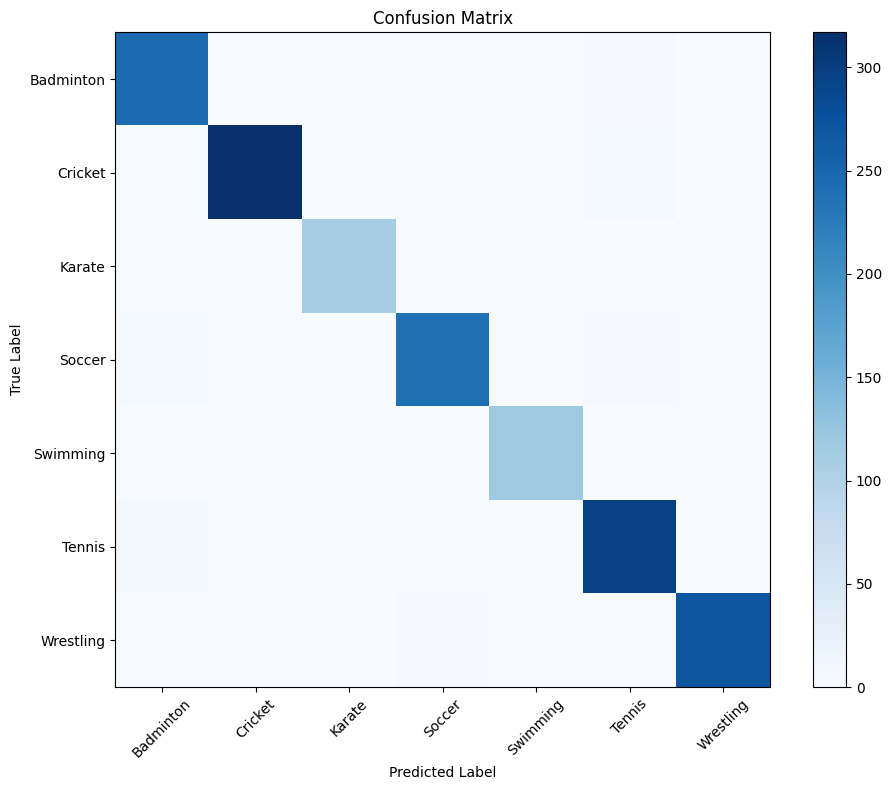

In [6]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_sports_model.pth'))
model.eval()

# Get predictions on validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
class_names = list(full_train_dataset.class_to_idx.keys())
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


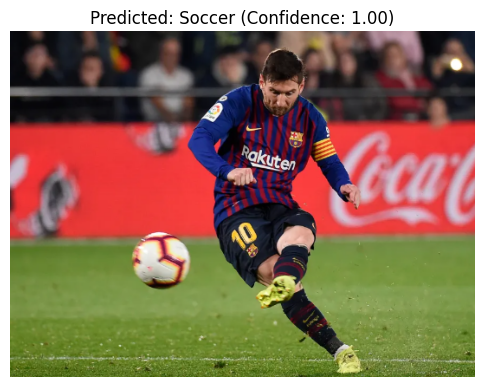

In [11]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms as T
import timm

# 1. Device and class names (reuse from your training setup)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['Badminton', 'Cricket', 'Karate', 'Soccer', 'Swimming', 'Tennis', 'Wrestling']

# 2. Validation transform (must match training)
val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# 3. Load the model architecture and weights
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=len(class_names))
model.load_state_dict(torch.load('/kaggle/working/best_sports_model.pth', map_location=device))
model.to(device)
model.eval()

# 4. Define predict_image
def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')
    tensor = val_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(tensor)
        probs = torch.nn.functional.softmax(outputs[0], dim=0)
        conf, pred_idx = torch.max(probs, dim=0)
    return class_names[pred_idx.item()], conf.item(), img

# 5. Run on the given image
image_path = "/kaggle/input/messi-freekick/Screenshot 2025-08-22 012824.png"
predicted_label, confidence, img = predict_image(image_path)

# 6. Display
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} (Confidence: {confidence:.2f})")
plt.show()


In [17]:
# 1) Install ffmpeg if needed (already present in most Kaggle kernels)
# 2) Convert video to H.264 MP4
!ffmpeg -y -i /kaggle/input/badminton-dataset/badminton.mp4 \
   -c:v libx264 -preset fast -crf 23 \
   /kaggle/working/converted1.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

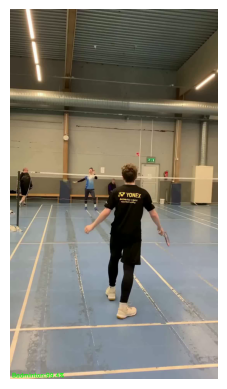

In [18]:
import cv2, torch, pandas as pd
from PIL import Image
from torchvision import transforms as T
import timm

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['Badminton','Cricket','Karate','Soccer','Swimming','Tennis','Wrestling']
val_transform = T.Compose([
    T.Resize((224,224)), T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=len(class_names))
model.load_state_dict(torch.load('/kaggle/working/best_sports_model.pth', map_location=device))
model.to(device).eval()

# Read converted video
cap = cv2.VideoCapture('/kaggle/working/converted1.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
w, h = int(cap.get(3)), int(cap.get(4))
out = cv2.VideoWriter('output.mp4', fourcc, fps, (w,h))

records = []
frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret: break

    pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    tensor = val_transform(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits[0], dim=0)
        conf, idx = torch.max(probs, dim=0)
    label, confidence = class_names[idx], conf.item()

    cv2.putText(frame, f"{label}:{confidence*100:.1f}%", (10,h-10),
                cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2,cv2.LINE_AA)
    out.write(frame)
    records.append((frame_idx, label, confidence))
    frame_idx += 1

cap.release(); out.release()
pd.DataFrame(records, columns=['frame','label','conf']).to_csv('predictions.csv', index=False)

# Show the first annotated frame inline
import cv2, matplotlib.pyplot as plt
cap2 = cv2.VideoCapture('output.mp4')
ret, first = cap2.read(); cap2.release()
plt.imshow(cv2.cvtColor(first, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()
